# MNIST - Ćwiczenie z ANN
Zanim zaczniemy pracę z konwolucyjnymi sieciami neuronowymi (CNN), zamodelujmy <a href='https://en.wikipedia.org/wiki/MNIST_database'>zestaw danych MNIST</a> wykorzystując wyłącznie warstwy liniowe.<br>
W tym ćwiczeniu użyjemy tej samej logiki, którą poznaliśmy w notatniku o sieciach ANN. Przekształcimy dane MNIST z obrazu 28x28 w spłaszczony wektor 1x784, aby odwzorować pojedynczy wiersz 784 cech.


## Wykonaj Standardowe Importy
Torchvision powinno zostać zainstalowane przez plik środowiska podczas konfiguracji. Jeśli tak się nie stało, możesz zainstalować je teraz. W terminalu z aktywowanym środowiskiem wirtualnym uruchom<br>
<pre>conda install torchvision -c pytorch
<em>lub</em>
pip install torchvision</pre>


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # dodaje nieco wydajności
from torch.utils.data import DataLoader  # umożliwia ładowanie danych partiami
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # do oceny wyników
import matplotlib.pyplot as plt
%matplotlib inline

## Wczytaj Zbiór Danych MNIST
PyTorch udostępnia zbiór danych MNIST poprzez <a href='https://docs.pytorch.org/vision/stable/index.html'><tt><strong>torchvision</strong></tt></a>. Przy pierwszym wywołaniu zestaw zostanie pobrany na komputer do wskazanej ścieżki. Od tej pory torchvision zawsze spróbuje skorzystać z lokalnej kopii, zanim ponowi pobieranie.
### Zdefiniuj Transformację
W ramach procesu wczytywania można zastosować wiele transformacji (zmianę kształtu, konwersję na tensor, normalizację itd.) do napływających danych.<br>
W tym ćwiczeniu musimy jedynie zamienić obrazy na tensory. 


In [2]:
transform = transforms.ToTensor()

### Wczytaj Zestaw Treningowy


In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Wczytaj Zestaw Testowy
Istnieje towarzyszący zbiór danych MNIST zawierający 10 000 rekordów, dostępny po ustawieniu parametru train=False. Podobnie jak wcześniej, torchvision pobierze go tylko raz, a później będzie szukać lokalnej kopii.


In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Przeanalizuj Rekord Treningowy


In [5]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Wywołanie pierwszego rekordu z <tt>train_data</tt> zwraca krotkę złożoną z dwóch elementów. Pierwszy element to tensor 28x28 reprezentujący obraz. Drugi to etykieta, w tym przypadku cyfra "5".


In [6]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### Wyświetl Obraz
Matplotlib może interpretować wartości pikseli przy pomocy różnych <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>map kolorów</a>.


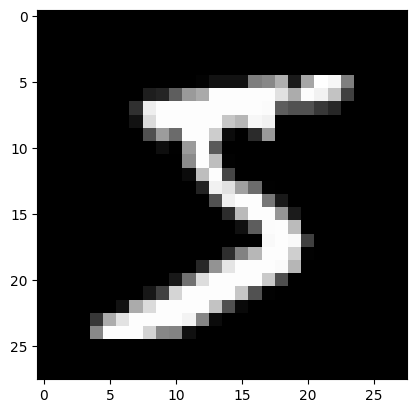

In [7]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

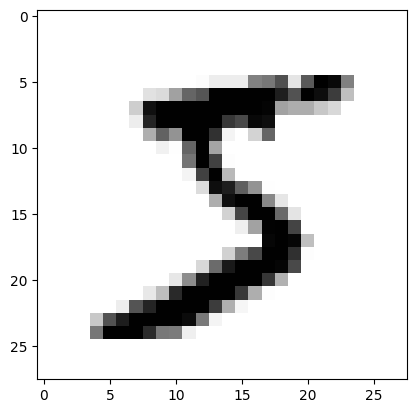

In [8]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

## Ładowanie Partiami z DataLoader
Nasz zbiór treningowy zawiera 60 000 rekordów.

Nasz model zbdujemy w następującej architekturze:

1. warstwa wejściowa: 784 neurony - bo mamy 784 cechy - każdy pixel to cecha
2. warstwy ukryte: 120 i 84 neurony (to arbitralny wybór)
3. warstwa wyjściowa: 10 neuronów - bo mamy

Wliczając wyrazy bias dla każdej warstwy, łączna liczba trenowanych parametrów wynosi:<br>

$\begin{split}\quad(784\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
94080+120+10080+84+840+10 &= 105,214\end{split}$<br>

Oczywiście nie jest to jedyna możliwa architektura. Często spotkać można np MLP (Multi Layer Perceptron): 784–300–100–10 (LeNet-300-100) lub prostszy 784–128–10 też działają świetnie.


<div style="background: lightgray">
📜 Ciekawostka historyczna – skąd nazwa **LeNet**?

**LeNet** to rodzina sieci neuronowych zaprojektowanych przez **Yanna LeCuna** i jego zespół na początku lat 90. Nazwa pochodzi od „LeCun Network”.

🔹 **1990–1998 – LeNet-1, LeNet-4, LeNet-5**

* Były to jedne z pierwszych **konwolucyjnych sieci neuronowych (CNN)**.
* Najbardziej znana jest **LeNet-5 (1998)**, stosowana m.in. w systemach rozpoznawania cyfr na czekach bankowych w USA.
* Architektura: warstwy konwolucyjne + pooling + warstwy gęste. To był przełom – pokazała, że **CNN-y mogą przewyższać klasyczne MLP** w zadaniach wizji komputerowej.

🔹 **2000–2010 – LeNet-300-100**

* Później w badaniach nad MNIST zaczęto używać także prostszego modelu MLP:
  [
  784 ;\rightarrow; 300 ;\rightarrow; 100 ;\rightarrow; 10
  ]
* Choć **nie jest to CNN**, nazwę **„LeNet” zachowano** dla spójności historycznej.
* Stał się on **popularnym baseline**: służył do porównań metod regularizacji, optymalizacji i różnych wariantów uczenia.

🔹 **Od 2012 – era „wielkich” CNN**

* Sukces **AlexNet (2012)** na ImageNet pokazał, że CNN-y skalują się do dużych problemów.
* Potem pojawiły się **VGG, ResNet, EfficientNet** i inne architektury, które dziś dominują w wizji komputerowej.
* Mimo to, **LeNet-5 i LeNet-300-100** pozostają ikonami w dydaktyce – pierwszymi „klasycznymi” sieciami testowanymi na MNIST.

---

👉 Dzięki temu, gdy widzisz nazwę **LeNet**, możesz ją traktować jako **historyczny hołd dla pionierskich prac LeCuna** – niezależnie od tego, czy chodzi o CNN (LeNet-5), czy o klasyczny MLP (LeNet-300-100).
</div>


Z powodu dużej ilości danych sensowne jest ładowanie danych treningowych partiami przy użyciu <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

**DataLoader** w PyTorchu to narzędzie, które **dzieli dane na partie (batch’e)** i **odpowiada za ich efektywne dostarczanie do modelu podczas uczenia i testowania**.

* `batch_size=100` → dane są podawane modelowi w paczkach po 100 próbek zamiast całego zbioru naraz (przyspiesza i stabilizuje uczenie).
* `shuffle=True` → dane treningowe są mieszane w każdej epoce, co zmniejsza ryzyko przeuczenia.
* `shuffle=False` → w testach zachowujemy stałą kolejność.

👉 Krótko mówiąc: **DataLoader automatyzuje batching, mieszanie i iterowanie po danych, co jest kluczowe dla trenowania sieci neuronowych.**



In [9]:
torch.manual_seed(101)  # dla powtarzalnych wyników

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

W powyższej komórce <tt><strong>train_data</strong></tt> jest obiektem <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> PyTorcha (obiekt wspierający wczytywanie i próbkowanie danych).<br>

<div class="alert alert-info"><strong>UWAGA:</strong> DataLoader przyjmuje opcjonalny parametr <tt><strong>num_workers</strong></tt>, który ustawia liczbę procesów podrzędnych używanych do wczytywania danych. Zachowuje się to różnie w zależności od systemu operacyjnego, dlatego tutaj go pomijamy. Zobacz <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>dokumentację</a>, aby dowiedzieć się więcej.</div>


### Wyświetl Partię Obrazów
Po zdefiniowaniu DataLoadera możemy stworzyć siatkę obrazów za pomocą <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>.


Labels:  [    7     2     3     5     8     5     3     6     9     9     1     3]


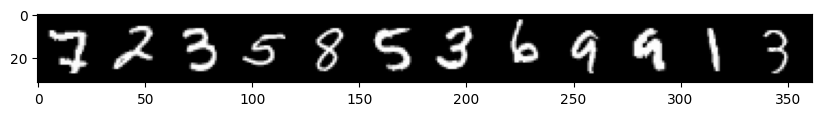

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # aby poszerzyć wyświetlaną tablicę
# bez tego: [2 0 2 0 3 7 4 1 2 2 2 3]
# z: [    0     7     0     9     2     1     4     4     5     7     2     4]

# Pobierz pierwszą partię obrazów

images,labels = next(iter(train_loader))

# Wypisz pierwsze 12 etykiet
print('Labels: ', labels[:12].numpy())

# Wyświetl pierwsze 12 obrazów
im = make_grid(images[:12], nrow=12)  # domyślna wartość nrow to 8
plt.figure(figsize=(10,4))
# Musimy przetransponować obrazy z CWH do WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Zdefiniuj Model

W tym ćwiczeniu użyjemy w pełni połączonych warstw, aby zbudować <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>wielowarstwowy perceptron</a>.<br>
Rozmiar wejścia wynosi 784, gdy spłaszczymy wchodzące tensory 28x28.<br>
Rozmiar wyjścia odpowiada 10 możliwym cyfrom.<br>
Warstwy ukryte ustawimy na [120, 84]. Po ukończeniu ćwiczenia śmiało wróć i wypróbuj inne wartości.


In [11]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [12]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

<div class="alert alert-info"><strong>UWAGA:</strong> Być może zauważyłeś skrót, którego użyliśmy do dodania ReLU do warstwy liniowej. W poprzedniej sekcji robiliśmy to w metodzie <tt>__init__</tt> tak jak poniżej:
<pre style='background-color:rgb(217,237,247)'>
layerlist = []
for i in layers:
    layerlist.append(nn.Linear(n_in,i)) 
    layerlist.append(nn.ReLU(inplace=True))
self.layers = nn.Sequential(*layerlist)</pre>
    
Tutaj wywołujemy <tt>F.relu()</tt> jako funkcję opakowującą liniową warstwę bezpośrednio:
<pre style='background-color:rgb(217,237,247)'>
def forward(self,X):
    X = F.relu(self.fc1(X))</pre></div>


## Policz Parametry Modelu
Ten opcjonalny krok pokazuje, że liczba trenowalnych parametrów w naszym modelu zgadza się z powyższym równaniem.


In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [14]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


## Zdefiniuj Funkcję Straty i Optymalizator


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Spłaszcz Dane Treningowe
Tensory partii zwracane przez DataLoader mają kształt [100, 1, 28, 28]:


In [16]:
# Wczytaj pierwszą partię i wypisz jej kształt
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# ODPOWIADA TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


Możemy je spłaszczyć przy pomocy <tt>.view()</tt>


In [17]:
images.view(100,-1).size()

torch.Size([100, 784])

Zrobimy to tuż przed zastosowaniem modelu do naszych danych.


## Trenuj Model
Tym razem będziemy przepuszczać dane testowe przez model w każdej epoce, aby móc porównać stratę i dokładność na tym samym wykresie.

<div class="alert alert-info"><strong>KRÓTKA UWAGA: </strong>W sekcji poniżej oznaczonej &nbsp;<tt><em>#Tally the number of correct predictions</em></tt> &nbsp;umieszczamy kod
<pre style='background-color:rgb(217,237,247)'>
predicted = torch.max(y_pred.data, 1)[1]</pre>
Wykorzystuje on funkcję <a href='https://pytorch.org/docs/stable/torch.html#torch.max'><tt><strong>torch.max()</strong></tt></a>. Funkcja <tt>torch.max()</tt> zwraca tensor wartości maksymalnych oraz tensor indeksów, pod którymi je znaleziono. W naszym kodzie prosimy o pozycje indeksów wartości maksymalnych wzdłuż wymiaru 1. Dzięki temu możemy dopasować przewidywania do etykiet obrazów.</div>


In [18]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Uruchom partie treningowe
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Zastosuj model
        y_pred = model(X_train.view(100, -1))  # Tutaj spłaszczamy X_train
        loss = criterion(y_pred, y_train)
 
        # Zlicz liczbę poprawnych predykcji
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Zaktualizuj parametry
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Wypisz wyniki pośrednie
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Zaktualizuj stratę i dokładność na zbiorze treningowym w tej epoce
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Uruchom partie testowe
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Zastosuj model
            y_val = model(X_test.view(500, -1))  # Tutaj spłaszczamy X_test

            # Zlicz liczbę poprawnych predykcji
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Zaktualizuj stratę i dokładność na zbiorze testowym w tej epoce
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # wypisz upływ czasu            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955006  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27259147  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18177132  accuracy:  89.315%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.16961813  accuracy:  94.635%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.05306605  accuracy:  95.032%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.14335893  accuracy:  95.250%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16369638  accuracy:  96.525%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.17127801  accuracy:  96.522%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.11085605  accuracy:  96.593%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.13777527  accuracy:  97.375%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01198216  accuracy:  97.453%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.08638886  accuracy:  97.410%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05678264  accuracy:  97.995%
epoch:  4  b

## Wykreśl Porównanie Straty i Dokładności


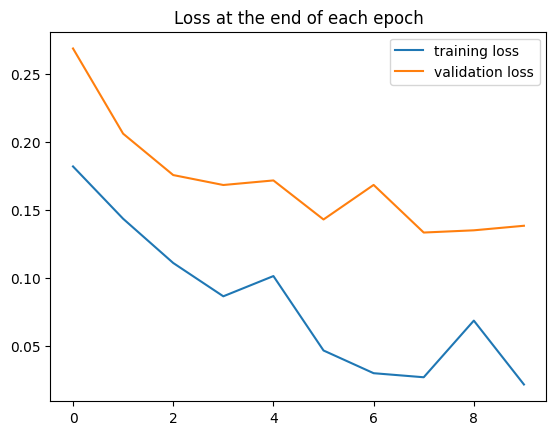

In [19]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

Widać tutaj pewne oznaki przeuczenia danych treningowych.


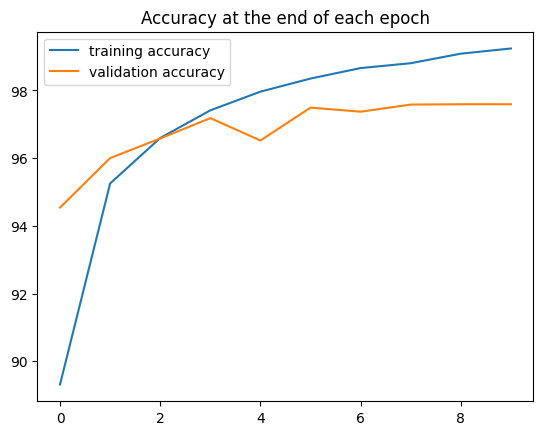

In [20]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Oceń Dane Testowe
Podczas trenowania zachowaliśmy wyniki na zbiorze testowym:


In [21]:
print(test_correct) # zawiera wyniki ze wszystkich 10 epok
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # wypisz najświeższy wynik w procentach

[tensor(9454), tensor(9600), tensor(9658), tensor(9718), tensor(9652), tensor(9749), tensor(9737), tensor(9758), tensor(9759), tensor(9759)]

Test accuracy: 97.590%


Chcielibyśmy jednak porównać przewidywane wartości z rzeczywistością (etykietami y_test), więc przepuścimy zbiór testowy przez wytrenowany model za jednym razem.


In [22]:
# Pobierz dane za jednym razem, a nie partiami
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [23]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # przekazujemy spłaszczony widok X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9759/10000 =  97.590%


Nieźle, biorąc pod uwagę, że losowe zgadywanie dałoby tylko 10% trafień!


## Wyświetl Macierz Pomyłek
Wykorzystujemy tutaj bibliotekę scikit-learn oraz przewidywane wartości uzyskane powyżej.


In [24]:
# Wypisz wiersz wartości referencyjnych
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# Wypisz macierz pomyłek
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    2    1    1    2    2    0    3    5]
 [   0 1123    1    0    1    1    3    6    0    3]
 [   4    3 1015    8    7    0    3   10    4    0]
 [   1    3    3  987    0   17    1    1    3   12]
 [   0    0    1    0  943    1    2    0    0    6]
 [   0    0    0    0    0  853    2    0    2    5]
 [   1    2    2    2    9    7  942    0    4    1]
 [   0    1    5    4    4    0    0 1005    2    4]
 [   2    3    2    6    3   10    3    4  954    8]
 [   0    0    1    2   14    1    0    2    2  965]]


Wynik pokazuje, że model osiągnął największe sukcesy dla jedynek, dwójek i siódemek, a najsłabiej radził sobie z piątkami, szóstkami i ósemkami.


## Przeanalizuj Pomyłki
Możemy śledzić indeksy nietrafionych przewidywań i wyciągnąć odpowiadające im obrazy oraz etykiety. Zrobimy to partiami, aby zaoszczędzić miejsce na ekranie.


In [25]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Wyświetl liczbę błędnych predykcji
len(misses)

241

In [26]:
# Wyświetl pierwszych 10 indeksów
misses[:10]

array([ 104,  115,  149,  151,  158,  241,  247,  259,  274,  321])

In [27]:
# Przygotuj iterator do dostarczania partii wierszy
r = 12   # liczba elementów w wierszu
row = iter(np.array_split(misses,len(misses)//r+1))

Teraz, gdy wszystko jest przygotowane, uruchamiaj wielokrotnie poniższą komórkę, aby zobaczyć wszystkie błędne przewidywania.<br>
Użyj <kbd>Ctrl+Enter</kbd>, aby pozostać w komórce między kolejnymi uruchomieniami. Po przejrzeniu wszystkich pomyłek zobaczysz wyjątek <tt>StopIteration</tt>.


Index: [ 104  115  149  151  158  241  247  259  274  321  340  381]
Label: [   9    4    2    9    3    9    4    6    9    2    5    3]
Guess: [   5    9    9    8    2    8    2    0    3    7    3    7]


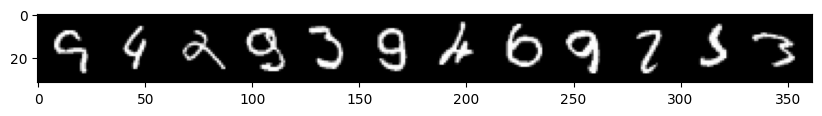

In [28]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Świetna Robota!
